<a href="https://colab.research.google.com/github/Kaushik-hub18/Voice-Data/blob/main/VoiceData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part 1: Dataset**

In [47]:
import os
import pandas as pd
import numpy as np


In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset inside Google Drive
dataset_path = "/content/drive/MyDrive/archive (2)"

# Check folder structure
os.listdir(dataset_path)[:5]  # Should list Actor_01, Actor_02, etc.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Actor_05', 'Actor_06', 'Actor_02', 'Actor_04', 'Actor_01']

In [3]:
audio_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))

print("Total audio files:", len(audio_files))
print("Example file:", audio_files[0])


Total audio files: 2880
Example file: /content/drive/MyDrive/archive (2)/Actor_05/03-01-08-02-02-01-05.wav



**Part 2: Preprocessing**

In [4]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt


In [5]:
def preprocess_audio(file_path, sr=16000):
    """
    Loads an audio file, converts to mono, resamples, trims silence, and normalizes.

    Args:
        file_path (str): Path to audio file
        sr (int): Target sampling rate (default 16kHz)

    Returns:
        signal (np.array): Preprocessed audio signal
        sr (int): Sampling rate
    """
    # Load audio (converts to mono + resamples)
    signal, sr = librosa.load(file_path, sr=sr, mono=True)

    # Trim leading & trailing silence
    signal, _ = librosa.effects.trim(signal)

    # Normalize audio to -1 to 1 range
    signal = signal / np.max(np.abs(signal))

    return signal, sr


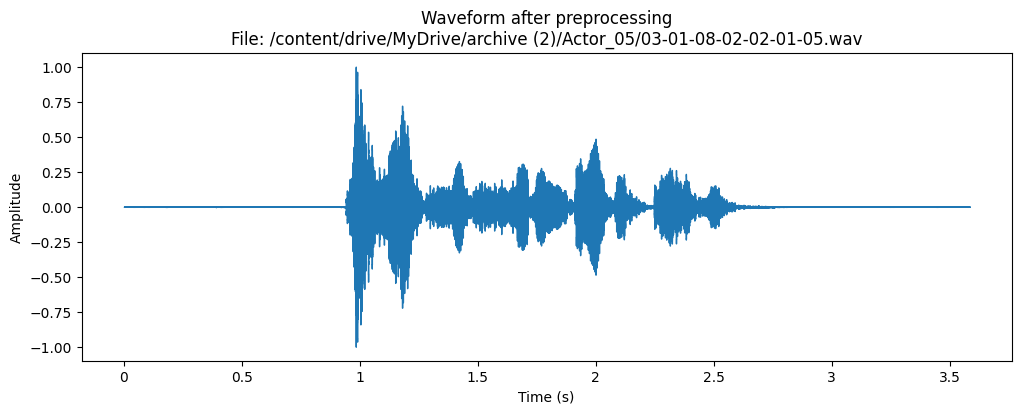

Length of processed signal: 57344
Sampling rate: 16000


In [6]:
# Pick one sample file
sample_file = audio_files[0]

# Preprocess
signal, sr = preprocess_audio(sample_file)

# Plot waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(signal, sr=sr)
plt.title(f"Waveform after preprocessing\nFile: {sample_file}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

print("Length of processed signal:", len(signal))
print("Sampling rate:", sr)


In [7]:
preprocessed_signals = []
for file in audio_files[:10]:  # first 10 for testing (you can remove [:10] later)
    signal, sr = preprocess_audio(file)
    preprocessed_signals.append(signal)

print(f"Preprocessed {len(preprocessed_signals)} audio files successfully!")


Preprocessed 10 audio files successfully!


**Part 3: Feature Extraction**

In [8]:
def extract_mfcc(signal, sr, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)  # take mean across time
    return mfccs, mfccs_mean


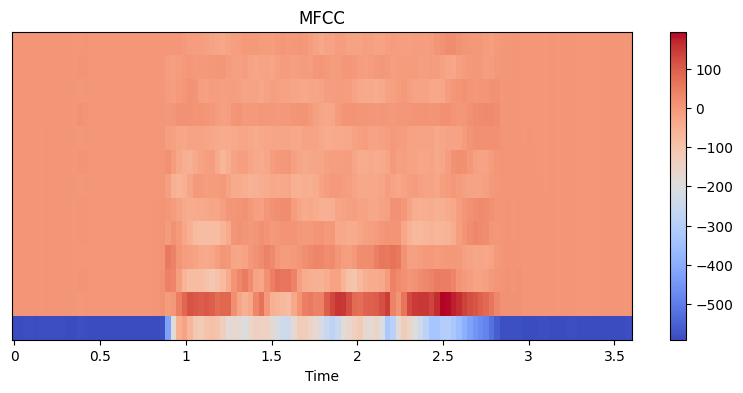

In [9]:
signal, sr = preprocess_audio(audio_files[0])
mfccs, mfccs_mean = extract_mfcc(signal, sr)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCC")
plt.show()


In [10]:
def extract_mel_spectrogram(signal, sr, n_mels=128):
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db


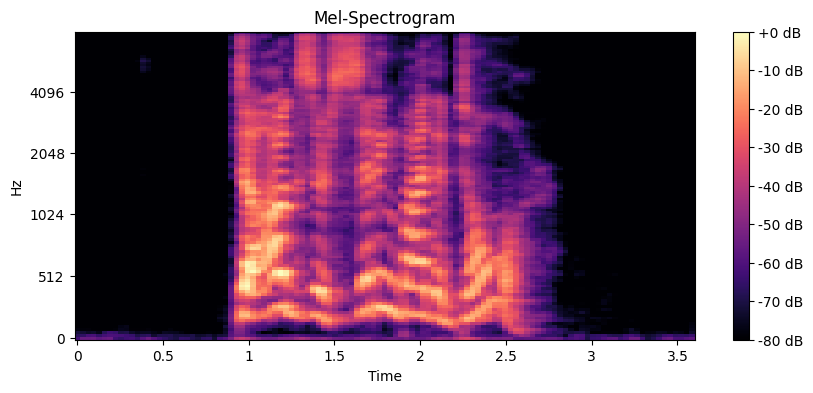

In [11]:
mel_spec_db = extract_mel_spectrogram(signal, sr)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel-Spectrogram")
plt.show()


In [12]:
def extract_chroma(signal, sr):
    stft = np.abs(librosa.stft(signal))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    chroma_mean = np.mean(chroma.T, axis=0)
    return chroma, chroma_mean


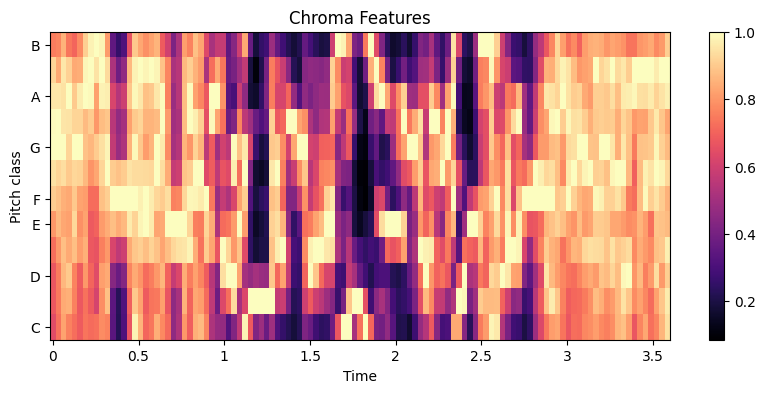

In [13]:
chroma, chroma_mean = extract_chroma(signal, sr)

plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sr)
plt.colorbar()
plt.title("Chroma Features")
plt.show()


In [16]:
# Emotion code mapping for RAVDESS
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}



In [18]:
print("Total audio files:", len(audio_files))


Total audio files: 2880


In [19]:
from tqdm import tqdm

features = []
labels = []

for path in tqdm(audio_files, desc="Extracting MFCCs"):
    signal, sr = preprocess_audio(path)
    _, mfccs_mean = extract_mfcc(signal, sr)
    features.append(mfccs_mean)

    # Emotion label
    emotion_code = os.path.basename(path).split('-')[2]
    labels.append(emotion_map[emotion_code])


X = np.array(features)
y = np.array(labels)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique emotions:", set(y))


Extracting MFCCs: 100%|██████████| 2880/2880 [13:17<00:00,  3.61it/s]

Feature matrix shape: (2880, 13)
Labels shape: (2880,)
Unique emotions: {np.str_('calm'), np.str_('fearful'), np.str_('disgust'), np.str_('sad'), np.str_('neutral'), np.str_('happy'), np.str_('angry'), np.str_('surprised')}


**Part 4: Model Building**

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Classes:", le.classes_)
print("Encoded labels:", y_encoded[:10])


Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Encoded labels: [7 7 7 7 7 7 7 3 0 3]


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (2304, 13) Test size: (576, 13)


In [22]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.3680555555555556

Classification Report:
               precision    recall  f1-score   support

       angry       0.49      0.50      0.50        76
        calm       0.37      0.44      0.40        77
     disgust       0.48      0.38      0.42        77
     fearful       0.35      0.42      0.38        77
       happy       0.33      0.34      0.34        77
     neutral       0.41      0.18      0.25        38
         sad       0.24      0.30      0.26        77
   surprised       0.38      0.30      0.33        77

    accuracy                           0.37       576
   macro avg       0.38      0.36      0.36       576
weighted avg       0.38      0.37      0.37       576



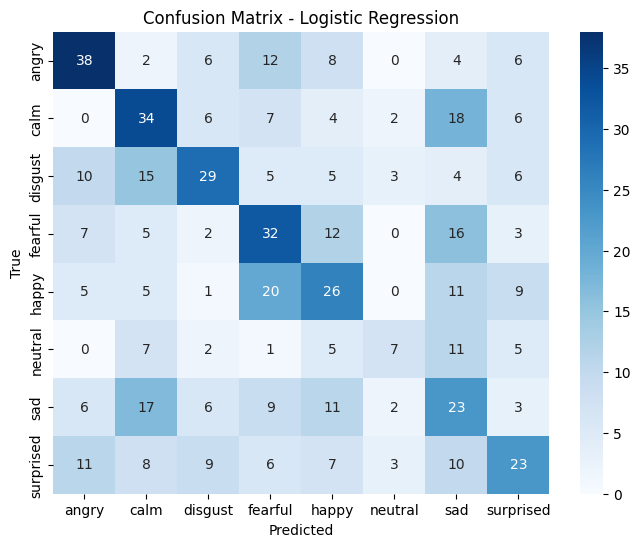

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [24]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_clf.predict(X_test)


Random Forest Accuracy: 0.9131944444444444

Classification Report:
               precision    recall  f1-score   support

       angry       0.92      0.92      0.92        76
        calm       0.91      1.00      0.95        77
     disgust       0.88      0.95      0.91        77
     fearful       0.86      0.92      0.89        77
       happy       0.88      0.97      0.93        77
     neutral       1.00      0.79      0.88        38
         sad       1.00      0.87      0.93        77
   surprised       0.94      0.82      0.88        77

    accuracy                           0.91       576
   macro avg       0.92      0.91      0.91       576
weighted avg       0.92      0.91      0.91       576



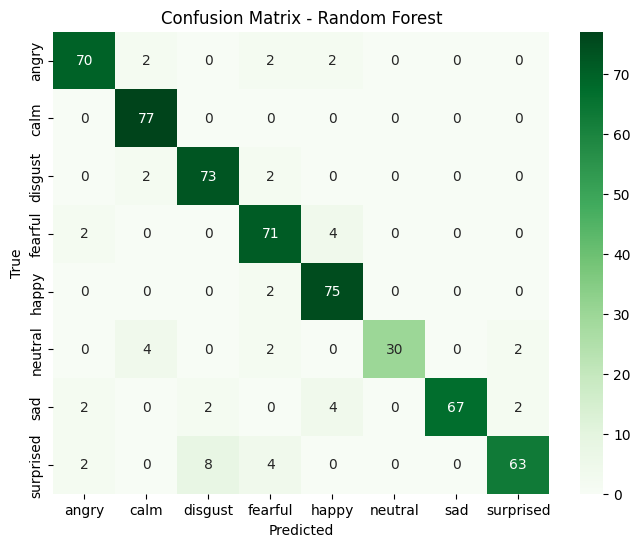

In [25]:
# Accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [26]:
import librosa
import numpy as np

def extract_mel_spectrogram(signal, sr, n_mels=128):
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# Example
signal, sr = preprocess_audio(audio_files[0])
mel_spec = extract_mel_spectrogram(signal, sr)

print("Mel-spectrogram shape:", mel_spec.shape)


Mel-spectrogram shape: (128, 113)


In [28]:
def pad_mel_spectrogram(mel_spec, max_len=128):
    """
    Pads or truncates a Mel-spectrogram to a fixed number of time frames.

    Args:
        mel_spec (np.array): Mel-spectrogram (n_mels x time_frames)
        max_len (int): Desired number of frames

    Returns:
        mel_spec_fixed (np.array): n_mels x max_len
    """
    n_mels, t = mel_spec.shape
    if t < max_len:
        # pad with zeros
        pad_width = max_len - t
        mel_spec = np.pad(mel_spec, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        # truncate
        mel_spec = mel_spec[:, :max_len]
    return mel_spec



In [29]:
X_cnn = []
y_cnn = []
max_len = 128  # you can adjust

for path in audio_files[:500]:  # smaller subset for testing
    signal, sr = preprocess_audio(path)
    mel_spec = extract_mel_spectrogram(signal, sr)
    mel_spec = pad_mel_spectrogram(mel_spec, max_len=max_len)
    mel_spec = np.expand_dims(mel_spec, axis=-1)  # add channel
    X_cnn.append(mel_spec)

    # label
    emotion_code = os.path.basename(path).split('-')[2]
    y_cnn.append(emotion_map[emotion_code])

X_cnn = np.array(X_cnn)
y_cnn = np.array(y_cnn)

print("CNN dataset shape:", X_cnn.shape)  # should be (num_samples, n_mels, max_len, 1)


CNN dataset shape: (500, 128, 128, 1)


In [31]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels
le_cnn = LabelEncoder()
y_cnn_encoded = le_cnn.fit_transform(y_cnn)

# One-hot encode for CNN
y_cnn_cat = to_categorical(y_cnn_encoded)


In [32]:
from sklearn.model_selection import train_test_split

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_cnn, y_cnn_cat, test_size=0.2, random_state=42, stratify=y_cnn_encoded
)

print("Train shape:", X_train_cnn.shape)
print("Test shape:", X_test_cnn.shape)


Train shape: (400, 128, 128, 1)
Test shape: (100, 128, 128, 1)


**Building CNN Model**

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = y_cnn_cat.shape[1]  # number of emotion classes

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=X_train_cnn.shape[1:]),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,776 (28.20 MB)

 Trainable params: 7,392,776 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history = model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=20,
    batch_size=32
)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 595ms/step - accuracy: 0.0986 - loss: 161.6586 - val_accuracy: 0.2100 - val_loss: 2.0865
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 493ms/step - accuracy: 0.1690 - loss: 3.0808 - val_accuracy: 0.1900 - val_loss: 2.0741
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 551ms/step - accuracy: 0.2097 - loss: 2.0291 - val_accuracy: 0.1400 - val_loss: 2.0812
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 563ms/step - accuracy: 0.1993 - loss: 2.0094 - val_accuracy: 0.1100 - val_loss: 2.0785
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 502ms/step - accuracy: 0.2040 - loss: 2.0007 - val_accuracy: 0.1500 - val_loss: 2.0819
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 564ms/step - accuracy: 0.2672 - loss: 1.9088 - val_accuracy: 0.1700 - val_loss: 2.0772
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 495ms/step - accuracy: 0.2717 - loss: 1.9263 - val_accuracy: 0.2400 - val_loss: 2.0832
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 503ms/step - accuracy: 0.3336 - loss: 1.8437 - val_accurac

In [35]:
test_loss, test_acc = model.evaluate(X_test_cnn, y_test_cnn)
print("CNN Test Accuracy:", test_acc)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.3063 - loss: 2.4304
CNN Test Accuracy: 0.3100000023841858


In [45]:
# Save model after training
model.save("cnn_model.h5")


In [46]:
from google.colab import files
files.download("cnn_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

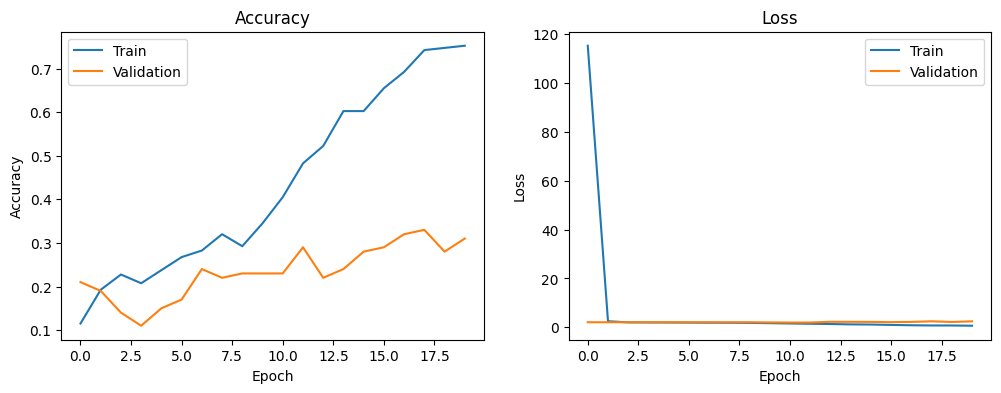

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Part 5: Evaluation & Comparison**

In [37]:
from sklearn.metrics import accuracy_score

acc_logreg = accuracy_score(y_test, y_pred)
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_cnn = test_acc  # already obtained from model.evaluate

print("Model Accuracies:")
print(f"Logistic Regression: {acc_logreg:.4f}")
print(f"Random Forest:       {acc_rf:.4f}")
print(f"CNN:                 {acc_cnn:.4f}")


Model Accuracies:
Logistic Regression: 0.3681
Random Forest:       0.9132
CNN:                 0.3100


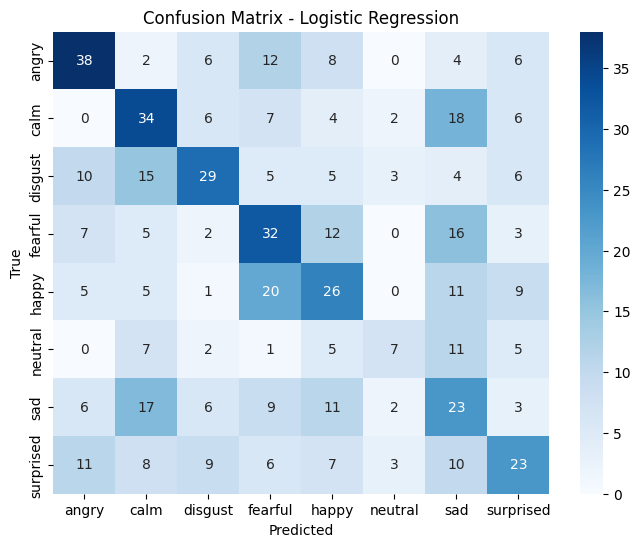

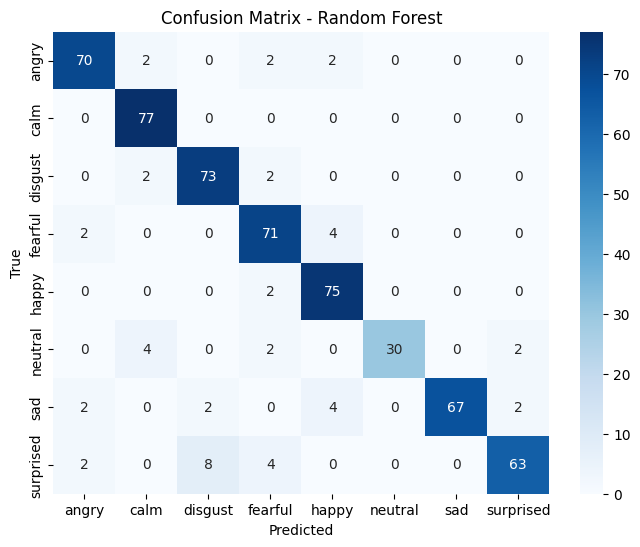

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Logistic Regression
plot_cm(y_test, y_pred, le.classes_, "Confusion Matrix - Logistic Regression")

# Random Forest
plot_cm(y_test, y_pred_rf, le.classes_, "Confusion Matrix - Random Forest")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


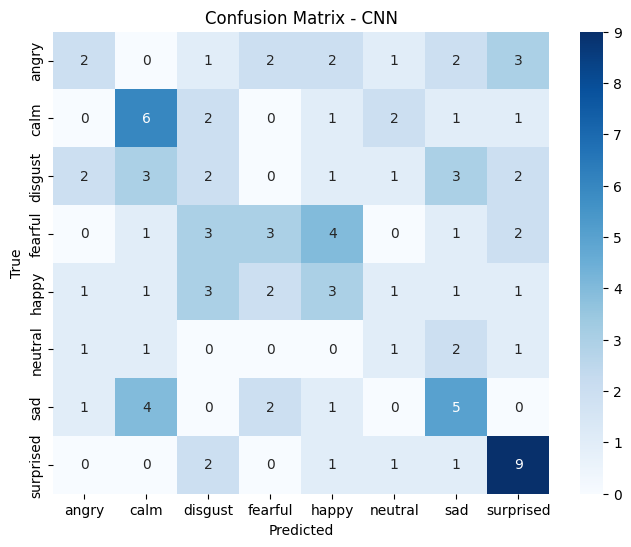

In [39]:
import numpy as np

y_test_labels = np.argmax(y_test_cnn, axis=1)
y_pred_labels = np.argmax(model.predict(X_test_cnn), axis=1)

plot_cm(y_test_labels, y_pred_labels, le_cnn.classes_, "Confusion Matrix - CNN")


In [40]:
import pandas as pd

comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "CNN"],
    "Accuracy": [acc_logreg, acc_rf, acc_cnn]
})

print(comparison)


                 Model  Accuracy
0  Logistic Regression  0.368056
1        Random Forest  0.913194
2                  CNN  0.310000


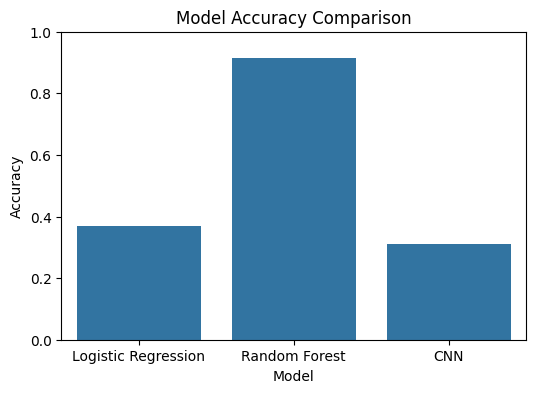

In [41]:
plt.figure(figsize=(6,4))
sns.barplot(x="Model", y="Accuracy", data=comparison)
plt.ylim(0,1)
plt.title("Model Accuracy Comparison")
plt.show()


**Part 6 (Optional) – Streamlit Demo App**

In [42]:
!pip install streamlit librosa soundfile numpy tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 50.6 MB/s eta 0:00:00
